# Download

Downloading products is after searching one of the most important features of `eodag`. This page describes the different methods available to download products and the parameters that these methods accept.

<div class="alert alert-warning">

Warning

Downloading products from a provider whose storage is based on AWS may incur some cost.

</div>

## Setup

Results obtained from *PEPS* after a search of *Sentinel 2 Level-1C* products over France in March 2021 will be loaded in a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult). But first, the credentials need to be set in order to be able to download anything.

In [1]:
import os
# os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
# os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

A workspace directory is created to store the downloaded products.

In [2]:
workspace = 'eodag_workspace_download'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

By default `eodag` saves products in the directory set by `outputs_prefix` which is by default the system temporary folder (`/tmp` on Linux) and quicklooks in a `quicklooks` subfolder of `outputs_prefix` (`tmp/quicklooks` on Linux). To make them easier to use, `eodag` even stores them in a standardized output tree, regardless of whether the products are stored in a file, folder or archive to be extracted (see below). The path of this tree is defined as `{outputs_prefix}/{title}`, with `title` the title of the products. Here `eodag` is configured to download products in this workspace directory.

In [3]:
os.environ["EODAG__PEPS__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

The `extract` setting could be also defined here. It indicates whether products need to be automatically extracted from their archive or not. They are extracted by default, this setting is not going to be altered here. The search result is finally loaded with [deserialize_and_register()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.deserialize_and_register).

In [4]:
# # This code cell has a special metadata entry: "nbsphinx": "hidden"
# # That hides it when the documentation is built with nbsphinx/sphinx.

# # Uncomment these lines to regenerate the GeoJSON file used in this notebook.

# from eodag.api.search_result import SearchResult

# dag.set_preferred_provider("peps")
# search_results = dag.search_all(
#    productType="S2_MSI_L1C",
#    start="2018-01-01",
#    end="2021-01-01",
#    geom={"lonmin": 1, "latmin": 45, "lonmax": 1.5, "latmax": 45.5},
# )
# combined_search_results = SearchResult([])
# offline_prods = [p for p in search_results if p.properties["storageStatus"] == "OFFLINE"]
# online_prods = [p for p in search_results if p.properties["storageStatus"] == "ONLINE"]
# if len(offline_prods) == 0 or len(online_prods) == 0:
#    raise ValueError("This search result must contain both ONLINE and OFFLINE products for the #notebook to be run correctly")
# combined_search_results.extend(online_prods[:5])
# combined_search_results.extend(offline_prods[:5])
# combined_search_results
# dag.serialize(combined_search_results, "data/download_search_results.geojson")

In [5]:
from eodag import EODataAccessGateway
dag = EODataAccessGateway()
search_results = dag.deserialize_and_register("data/download_search_results.geojson")
print(f"This SearchResult stores {len(search_results)} {search_results[0].product_type} products.")

This SearchResult stores 10 S2_MSI_L1C products.


`delete_archive` is another setting that allows to remove the archive containing products after its extraction, or not. The deletion is activated by default.

Logging is set to see more about what `eodag` does when it downloads products.

In [6]:
from eodag import setup_logging
setup_logging(2)

## Progress bar

`eodag` displays a progress bar every time it downloads products or quicklooks. It uses `tqdm.auto` to create a
 progress bar adapted to the context (Notebook, terminal).
 
### Cutomize progress bar

Progress bars can be customized, using the `progress_callback` parameter of the download methods. Create your own instance of [ProgressCallback](../../api_reference/utils.rst#eodag.utils.ProgressCallback) class, customize it to pass it later to [download](./7_download.ipynb#Download-EO-products) methods:

In [7]:
from eodag.utils import ProgressCallback

with ProgressCallback(total=3, unit="carrots", unit_scale=False, desc="Eating carrots") as progress_callback:
    progress_callback(1)
    progress_callback(2)

Eating carrots:   0%|          | 0/3 [00:00<?, ?carrots/s]

Keep another progress bar opened, and customize it changing `ProgressCallback` [attributes inherited from tqdm](https://github.com/tqdm/tqdm/#documentation):

In [8]:
another_bar = ProgressCallback(dynamic_ncols=False, ncols=300)
another_bar.colour = "purple"

0.00B [00:00, ?B/s]

In [9]:
another_bar(1)

### Mute progress bar

Progress bars can be muted using `setup_logging` and `0` as verbosity level, or `no_progress_bar` parameter.

In [10]:
with ProgressCallback(total=2) as progress_callback:
    progress_callback.desc = "This will be displayed"
    progress_callback.position = 0
    progress_callback(1)
    
setup_logging(verbose=0)

with ProgressCallback() as progress_callback:
    progress_callback.desc = "This will be hidden"
    progress_callback.position = 1
    progress_callback(1)

setup_logging(verbose=2, no_progress_bar=True)

with ProgressCallback() as progress_callback:
    progress_callback.desc = "This will be hidden"
    progress_callback.position = 2
    progress_callback(1)
    
setup_logging(verbose=2)

with ProgressCallback() as progress_callback:
    progress_callback.desc = "This will be also displayed"
    progress_callback.position = 3
    progress_callback(1)
    
with ProgressCallback(disable=True) as progress_callback:
    progress_callback.desc = "This will be hidden"
    progress_callback.position = 4
    progress_callback(1)

  0%|          | 0.00/2.00 [00:00<?, ?B/s]

0.00B [00:00, ?B/s]

## Already downloaded product

An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has a `location` attribute that stores either its remote location (before being downloaded) or its local location (after being downloaded). The download methods of `eodag` checks first wheter the product/quicklook to download has been already downloaded. If so, it just returns its path and does not try to download it again.

## Download quicklooks

EO products usually offer a *quicklook* image, a low resolution by-product of the original data. An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has a [get_quicklook()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.get_quicklook) method that takes care of downloading the quicklook image and returns its path. It accepts a `base_dir` (optional) parameter to specify an output directory and a `filename` (optional) parameter to specify an output filename. By default, `eodag` saves a quicklook with its ID as filename.

[get_quicklook()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.get_quicklook) returns the local absolute path to the image downloaded. This is useful to precess it afterwards. Here `matplotlib` is used here to display 4 quicklooks.

0.00B [00:00, ?B/s]

2023-10-18 14:53:31,315 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2B_MSIL1C_20201231T105349_N0500_R051_T31TCK_20230328T212259


0.00B [00:00, ?B/s]

2023-10-18 14:53:31,668 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2B_MSIL1C_20201231T105349_N0500_R051_T31TCL_20230328T212259


0.00B [00:00, ?B/s]

2023-10-18 14:53:32,179 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2A_MSIL1C_20201229T110451_N0500_R094_T31TCL_20230328T144935


0.00B [00:00, ?B/s]

2023-10-18 14:53:32,630 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2A_MSIL1C_20201226T105451_N0500_R051_T31TCL_20230328T002707


0.00B [00:00, ?B/s]

2023-10-18 14:53:33,096 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2A_MSIL1C_20201226T105451_N0500_R051_T31TCK_20230328T002707


0.00B [00:00, ?B/s]

2023-10-18 14:53:33,549 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2B_MSIL1C_20201201T105419_N0209_R051_T31TCL_20201201T115506


0.00B [00:00, ?B/s]

2023-10-18 14:53:33,961 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2B_MSIL1C_20201201T105419_N0209_R051_T31TCK_20201201T115506


0.00B [00:00, ?B/s]

2023-10-18 14:53:34,534 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2B_MSIL1C_20201111T105259_N0209_R051_T31TCK_20201111T130651


0.00B [00:00, ?B/s]

2023-10-18 14:53:35,263 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2B_MSIL1C_20201111T105259_N0209_R051_T31TCL_20201111T130651


0.00B [00:00, ?B/s]

2023-10-18 14:53:35,785 eodag.product                    [INFO    ] Download recorded in /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/quicklooks/S2B_MSIL1C_20200902T104629_N0209_R051_T31TCK_20200902T121149


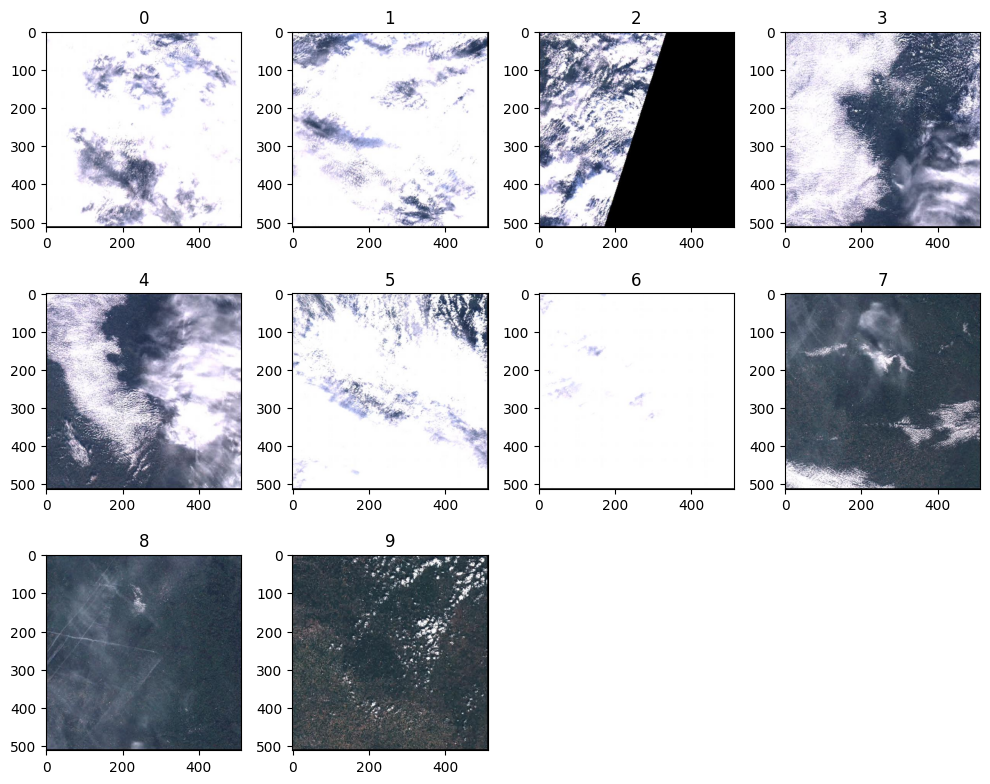

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 8))
for i, product in enumerate(search_results, start=1):
    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()
    
    # Plot the quicklook
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(3, 4, i)
    ax.set_title(i - 1)
    plt.imshow(img)
plt.tight_layout()

## Download EO products

### Dynamically configure some download options

The 3 download methods introduced below accept the following optional kwargs that temporarily override the global configuration:

* `outputs_prefix` (`str`): absolute path to a folder where the products should be saved
* `extract` (`bool`): whether to automatically extract or not the downloaded product archive
* `dl_url_params` (`dict`): additional parameters to pass over to the download url as an url parameter
* `delete_archive` (`bool`): whether to delete the downloaded archives

### Order OFFLINE products

As introduced in the [getting started guide](../../getting_started_guide/product_storage_status.rst) an EO product may not be available for download immediately. If the product status is `OFFLINE`, the download methods will request an order of the product and, by default, retry to download it every 2 minutes during 20 minutes. These two durations can be set with the `wait` (in minutes) and `timeout` (in minutes) optional parameters of all the download methods.

The storage status of a product can be obtained from its `storageStatus` field. The status of an `OFFLINE` product is updated by `eodag` to `STAGING` when ordered and to `ONLINE` when found available.

In [12]:
[p.properties["storageStatus"] for p in search_results]

['ONLINE',
 'ONLINE',
 'ONLINE',
 'ONLINE',
 'ONLINE',
 'OFFLINE',
 'OFFLINE',
 'OFFLINE',
 'OFFLINE',
 'OFFLINE']

A `FilterProperty` can be used to filter out `OFFLINE` products to avoid triggering any product order. 

In [13]:
online_search_results = search_results.filter_property(
    storageStatus="ONLINE"
)
[p.properties["storageStatus"] for p in online_search_results]

2023-10-18 14:53:40,104 eodag.crunch.property            [INFO    ] Finished filtering products. 5 resulting products


['ONLINE', 'ONLINE', 'ONLINE', 'ONLINE', 'ONLINE']

### Download multiple products at once

[EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) offers a [download_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download_all) method that takes a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) argument and will try to download each [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) it contains. It returns a list of absolute paths to the downloaded products. For the purpose of this user guide only 2 products will be downloaded.

In [14]:
products_to_download = online_search_results[2:4]
paths = dag.download_all(products_to_download)

2023-10-18 14:53:40,408 eodag.core                       [INFO    ] Downloading 2 products


Downloaded products:   0%|          | 0/2 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

2023-10-18 14:53:40,447 eodag.download.base              [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/6f9f68b8-b278-55fb-8cb7-df0e983a5ce2/download


2023-10-18 14:57:22,213 eodag.download.base              [INFO    ] Extraction activated
2023-10-18 14:57:23,489 eodag.download.base              [INFO    ] Deleting archive S2A_MSIL1C_20201229T110451_N0500_R094_T31TCL_20230328T144935.zip
2023-10-18 14:57:23,560 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/6f9f68b8-b278-55fb-8cb7-df0e983a5ce2/download


0.00B [00:00, ?B/s]

2023-10-18 14:57:23,575 eodag.download.base              [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/d0cc77dd-d4bb-5b9c-8be6-e9e454ca5924/download
2023-10-18 15:04:57,850 eodag.download.base              [INFO    ] Extraction activated
2023-10-18 15:05:00,652 eodag.download.base              [INFO    ] Deleting archive S2A_MSIL1C_20201226T105451_N0500_R051_T31TCL_20230328T002707.zip
2023-10-18 15:05:00,781 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/d0cc77dd-d4bb-5b9c-8be6-e9e454ca5924/download


In [15]:
paths

['/home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2A_MSIL1C_20201229T110451_N0500_R094_T31TCL_20230328T144935',
 '/home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2A_MSIL1C_20201226T105451_N0500_R051_T31TCL_20230328T002707']

The products have been downloaded as archived files (*Sentinel* products are distributed in the [SAFE format](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats)). The logs above and the command below show that `eodag` then took care of extracting them to their own directory and deleting them afterward.

In [16]:
!ls {workspace}

quicklooks
S2A_MSIL1C_20201226T105451_N0500_R051_T31TCL_20230328T002707
S2A_MSIL1C_20201229T110451_N0500_R094_T31TCL_20230328T144935


In [17]:
!ls {paths[0]}

AUX_DATA   GRANULE  INSPIRE.xml    MTD_MSIL1C.xml
DATASTRIP  HTML     manifest.safe  rep_info


`eodag` saves a file in the `outputs_prefix` folder that contains a hash list of the products downloaded. Before downloading products, this file is read and it is checked whether the products to download were already downloaded or not. If they were, their download is skipped.

In [18]:
products_to_download = online_search_results[2:4]
dag.download_all(products_to_download)

2023-10-18 15:05:02,889 eodag.core                       [INFO    ] Downloading 2 products


Downloaded products:   0%|          | 0/2 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

2023-10-18 15:05:02,942 eodag.download.base              [INFO    ] Product already present on this platform. Identifier: /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2A_MSIL1C_20201229T110451_N0500_R094_T31TCL_20230328T144935
2023-10-18 15:05:02,943 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/6f9f68b8-b278-55fb-8cb7-df0e983a5ce2/download


0.00B [00:00, ?B/s]

2023-10-18 15:05:02,987 eodag.download.base              [INFO    ] Product already present on this platform. Identifier: /home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2A_MSIL1C_20201226T105451_N0500_R051_T31TCL_20230328T002707
2023-10-18 15:05:02,988 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/d0cc77dd-d4bb-5b9c-8be6-e9e454ca5924/download


['/home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2A_MSIL1C_20201229T110451_N0500_R094_T31TCL_20230328T144935',
 '/home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2A_MSIL1C_20201226T105451_N0500_R051_T31TCL_20230328T002707']

### Download a single product

[EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) also offers a [download()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download) method that takes an [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) argument and will try to download it. It is a wrapper around the [download()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.download) method that each [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has. Its advantage over the latter is that, similarly to what does [deserialize_and_register()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.deserialize_and_register), it adds the information required for a product to download itself if it was missing. It does so by extracting the product's provider and getting the right authentication and download plugins. Both methods return the absolute path to the downloaded product.

### Download an OFFLINE product

This examples shows what logs `eodag` emits when it tries to download a product that is originally `OFFLINE`. It is set to retry downloading the product every 1 minute after ordering it, and to stop trying (skip it if [download_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.download_all) is used) after 5 minutes.

In [19]:
offline_product = search_results.filter_property(
    storageStatus="OFFLINE"
)[1]
offline_product.properties["storageStatus"]

2023-10-18 15:05:03,154 eodag.crunch.property            [INFO    ] Finished filtering products. 5 resulting products


'OFFLINE'

In [20]:
path = dag.download(
    offline_product,
    wait=1,
    timeout=10,
)

0.00B [00:00, ?B/s]

2023-10-18 15:05:03,330 eodag.download.base              [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/2e5a5258-8b84-5a77-a04c-264429706c93/download
2023-10-18 15:11:08,011 eodag.download.base              [INFO    ] Extraction activated
2023-10-18 15:11:09,899 eodag.download.base              [INFO    ] Deleting archive S2B_MSIL1C_20201201T105419_N0209_R051_T31TCK_20201201T115506.zip
2023-10-18 15:11:10,005 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/2e5a5258-8b84-5a77-a04c-264429706c93/download


In [21]:
path

'/home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2B_MSIL1C_20201201T105419_N0209_R051_T31TCK_20201201T115506'

Now the `location` attribute rightfully points to its local path.

In [22]:
offline_product.location

'file:///home/anesson/workspace/EODAG/dev/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2B_MSIL1C_20201201T105419_N0209_R051_T31TCK_20201201T115506'

## Download assets

Searching on some providers (mainly STAC providers) returns products having an `assets` attribute listing single files that can be individually donwloaded.

In [5]:
search_results, total_count = dag.search(
    productType="S2_MSI_L2A", 
    provider="planetary_computer"
)

In [6]:
# view assets keys
[*search_results[0].assets]

['AOT',
 'B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B09',
 'B11',
 'B12',
 'B8A',
 'SCL',
 'WVP',
 'visual',
 'preview',
 'safe-manifest',
 'granule-metadata',
 'inspire-metadata',
 'product-metadata',
 'datastrip-metadata',
 'tilejson',
 'rendered_preview']

In [7]:
# view single asset content
search_results[0].assets["B05"]

{'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/04/V/DM/2023/11/30/S2B_MSIL2A_20231130T221859_N0509_R115_T04VDM_20231130T231119.SAFE/GRANULE/L2A_T04VDM_A035176_20231130T221857/IMG_DATA/R20m/T04VDM_20231130T221859_B05_20m.tif', 'proj:bbox': [399960.0, 6590220.0, 509760.0, 6700020.0], 'proj:shape': [5490, 5490], 'proj:transform': [20.0, 0.0, 399960.0, 0.0, -20.0, 6700020.0], 'gsd': 20.0, 'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'Band 5 - Vegetation red edge 1 - 20m', 'eo:bands': [{'name': 'B05', 'common_name': 'rededge', 'description': 'Band 5 - Vegetation red edge 1', 'center_wavelength': 0.704, 'full_width_half_max': 0.019}]}

Configure provider for download, if not already done

In [8]:
dag.update_providers_config(f"""
    planetary_computer:
        auth:
            credentials:
                apikey: PLEASE_CHANGE_ME
        download:
            outputs_prefix: {os.path.abspath(workspace)}
""")


Download several assets using core `download()` method, allowing regex in `asset` parameter to identify assets to download

In [9]:
path = dag.download(search_results[0], asset=r"B0[23]")
path

0.00B [00:00, ?B/s]

'/home/sylvain/workspace/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2B_MSIL2A_20231130T221859_R115_T04VDM_20231130T231119'

In [10]:
! ls {path}

T04VDM_20231130T221859_B02_10m.tif  T04VDM_20231130T221859_B03_10m.tif


Download a single asset using `asset.download()` method

In [11]:
path = search_results[0].assets["B05"].download()
path

0.00B [00:00, ?B/s]

'/home/sylvain/workspace/eodag/docs/notebooks/api_user_guide/eodag_workspace_download/S2B_MSIL2A_20231130T221859_R115_T04VDM_20231130T231119'

In [12]:
! ls {path}

T04VDM_20231130T221859_B02_10m.tif  T04VDM_20231130T221859_B05_20m.tif
T04VDM_20231130T221859_B03_10m.tif
